📊 COMPREHENSIVE TOURISM ANALYSIS DASHBOARD

📂 Loading datasets...
✅ Tourist Data: 8253 records
✅ Festival Data: 500 records
✅ Cost Data: 121 records

🔄 Preparing metrics...
✅ Tourist arrivals calculated for 0 countries
✅ Festival impact calculated for 20 countries
✅ Cost affordability calculated for 121 countries

🔗 Merging datasets...
✅ Merged dataset contains 20 countries
   Average Combined Score: 0.354

📊 Generating dashboard visualizations...
✅ Dashboard saved as 'combined_dashboard.png'


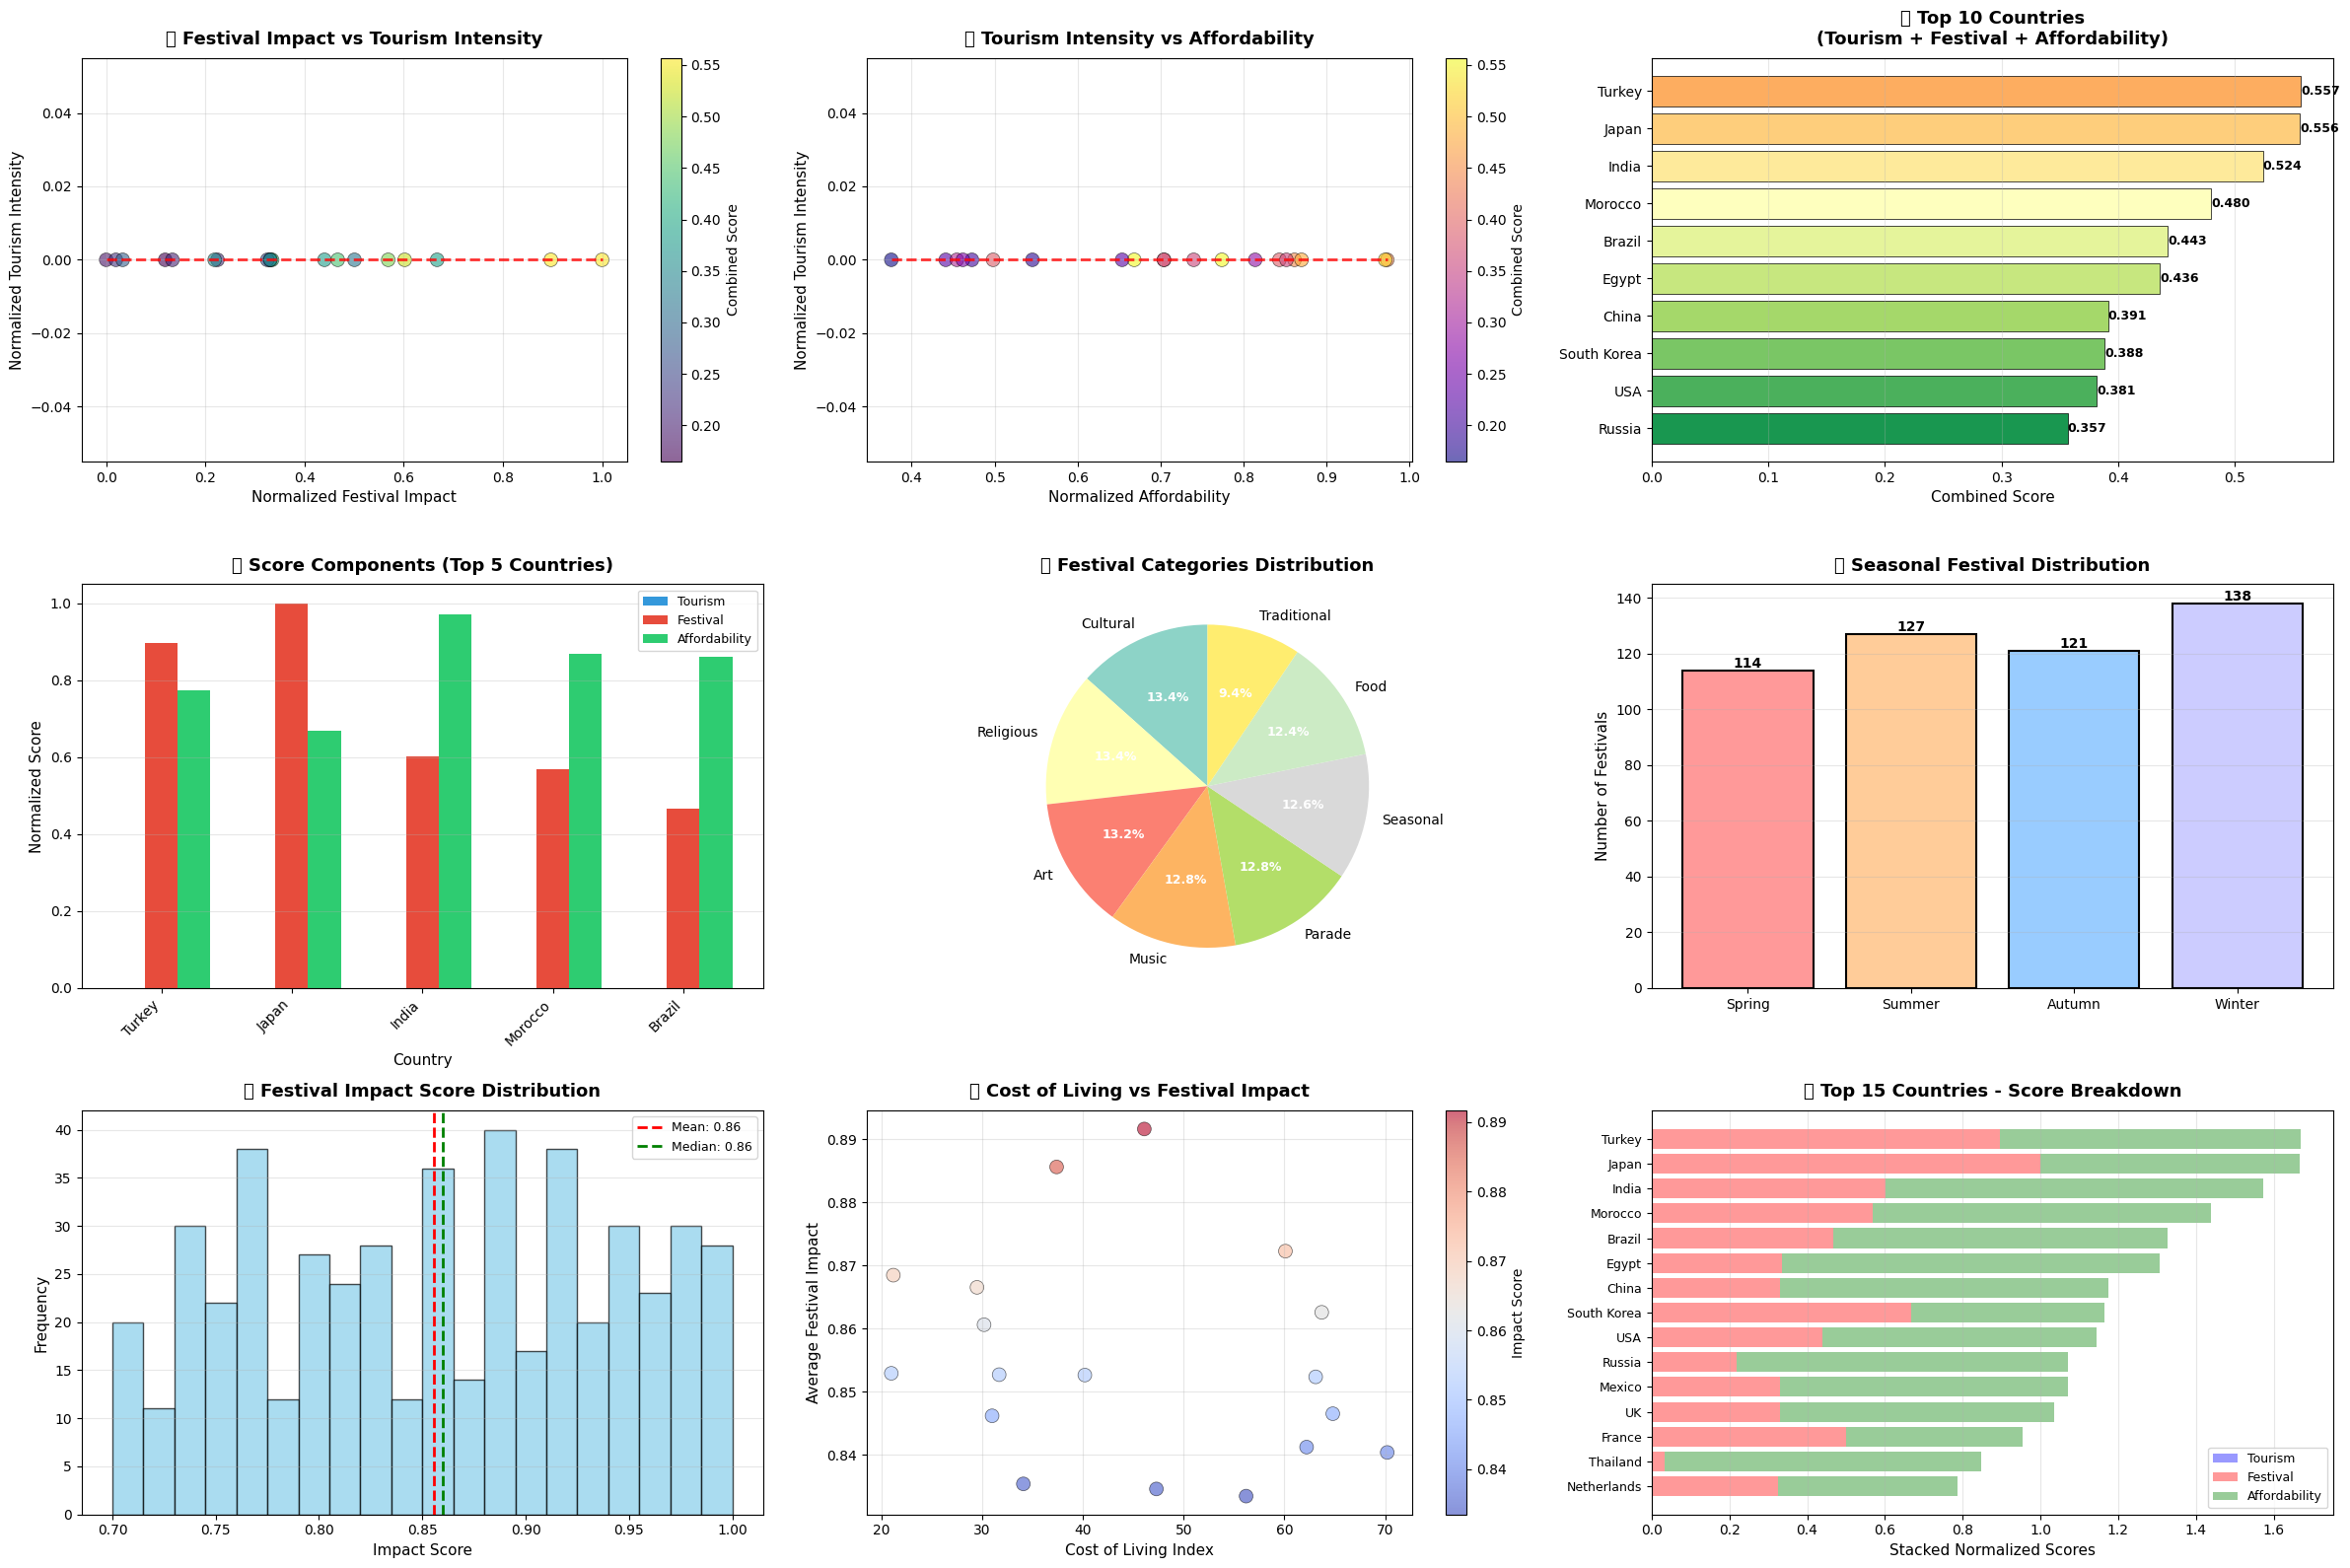

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("📊 COMPREHENSIVE TOURISM ANALYSIS DASHBOARD")
print("="*80)

# ============================================================================
# STEP 1: LOAD DATASETS
# ============================================================================
print("\n📂 Loading datasets...")

tourist_df = pd.read_csv('E:\\FDVA\\data\\processed\\tourist_processed.csv')
festival_df = pd.read_csv('E:\\FDVA\\data\\processed\\festivals_processed.csv')
cost_df = pd.read_csv('E:\\FDVA\\data\\processed\\cost_processed.csv')

# Strip whitespace from column names
tourist_df.columns = tourist_df.columns.str.strip()
festival_df.columns = festival_df.columns.str.strip()
cost_df.columns = cost_df.columns.str.strip()

print(f"✅ Tourist Data: {len(tourist_df)} records")
print(f"✅ Festival Data: {len(festival_df)} records")
print(f"✅ Cost Data: {len(cost_df)} records")

# ============================================================================
# STEP 2: PREPARE METRICS
# ============================================================================
print("\n🔄 Preparing metrics...")

# --- Tourist Average Arrivals ---
if 'Metric' in tourist_df.columns:
    tourist_arrivals = tourist_df[tourist_df['Metric'] == 'Arrivals'].copy()
else:
    tourist_arrivals = tourist_df.copy()

# Get year columns
year_cols = [col for col in tourist_arrivals.columns if col.isdigit() and 1995 <= int(col) <= 2023]

if len(year_cols) > 0:
    # Melt to long format
    tourist_long = tourist_arrivals.melt(
        id_vars=['Country'], 
        value_vars=year_cols,
        var_name='Year', 
        value_name='Arrivals'
    ).dropna()
    
    # Average arrivals per country
    tourist_avg = tourist_long.groupby('Country')['Arrivals'].mean().reset_index()
    tourist_avg.columns = ['Country', 'Avg_Arrivals']
    
    # Normalize
    if len(tourist_avg) > 0:
        tourist_avg['Norm_Tourism'] = (
            (tourist_avg['Avg_Arrivals'] - tourist_avg['Avg_Arrivals'].min()) / 
            (tourist_avg['Avg_Arrivals'].max() - tourist_avg['Avg_Arrivals'].min())
        )
    print(f"✅ Tourist arrivals calculated for {len(tourist_avg)} countries")
else:
    print("⚠️  No year columns found in tourist data")
    tourist_avg = pd.DataFrame(columns=['Country', 'Avg_Arrivals', 'Norm_Tourism'])

# --- Festival Impact ---
festival_country = festival_df.groupby('Country')['Impact_Score'].mean().reset_index()
festival_country.columns = ['Country', 'Avg_Impact']

if len(festival_country) > 0:
    festival_country['Norm_Festival'] = (
        (festival_country['Avg_Impact'] - festival_country['Avg_Impact'].min()) / 
        (festival_country['Avg_Impact'].max() - festival_country['Avg_Impact'].min())
    )
print(f"✅ Festival impact calculated for {len(festival_country)} countries")

# --- Cost Affordability (inverse: lower cost = higher affordability) ---
if 'Cost of Living Index' in cost_df.columns:
    cost_processed = cost_df[['Country', 'Cost of Living Index']].copy()
    cost_processed = cost_processed.dropna()
    
    if len(cost_processed) > 0:
        cost_processed['Norm_Cost'] = (
            (cost_processed['Cost of Living Index'] - cost_processed['Cost of Living Index'].min()) / 
            (cost_processed['Cost of Living Index'].max() - cost_processed['Cost of Living Index'].min())
        )
        # Affordability is inverse of cost
        cost_processed['Norm_Affordability'] = 1 - cost_processed['Norm_Cost']
    print(f"✅ Cost affordability calculated for {len(cost_processed)} countries")
else:
    print("⚠️  Cost of Living Index not found")
    cost_processed = pd.DataFrame(columns=['Country', 'Cost of Living Index', 'Norm_Cost', 'Norm_Affordability'])

# ============================================================================
# STEP 3: MERGE FOR DASHBOARD
# ============================================================================
print("\n🔗 Merging datasets...")

# Start with festival data (most complete)
merged = festival_country[['Country', 'Avg_Impact', 'Norm_Festival']].copy()

# Merge tourist data
if len(tourist_avg) > 0:
    merged = pd.merge(merged, tourist_avg[['Country', 'Avg_Arrivals', 'Norm_Tourism']], 
                     on='Country', how='left')
else:
    merged['Norm_Tourism'] = 0

# Merge cost data
if len(cost_processed) > 0:
    merged = pd.merge(merged, cost_processed[['Country', 'Norm_Affordability']], 
                     on='Country', how='left')
else:
    merged['Norm_Affordability'] = 0.5

# Fill NaN values with median
merged['Norm_Tourism'] = merged['Norm_Tourism'].fillna(merged['Norm_Tourism'].median())
merged['Norm_Affordability'] = merged['Norm_Affordability'].fillna(merged['Norm_Affordability'].median())

# Combined Score = Tourism + Festival + Affordability (equal weights)
merged['Combined_Score'] = (
    merged['Norm_Tourism'] + 
    merged['Norm_Festival'] + 
    merged['Norm_Affordability']
) / 3

print(f"✅ Merged dataset contains {len(merged)} countries")
print(f"   Average Combined Score: {merged['Combined_Score'].mean():.3f}")

# ============================================================================
# STEP 4: CREATE COMPREHENSIVE DASHBOARD
# ============================================================================
print("\n📊 Generating dashboard visualizations...")

fig = plt.figure(figsize=(24, 16))

# --- 4.1 Festival Impact vs Tourism ---
ax1 = plt.subplot(3, 3, 1)
valid_data = merged.dropna(subset=['Norm_Festival', 'Norm_Tourism'])
scatter1 = ax1.scatter(valid_data['Norm_Festival'], valid_data['Norm_Tourism'], 
                      c=valid_data['Combined_Score'], cmap='viridis', 
                      s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel("Normalized Festival Impact", fontsize=11)
ax1.set_ylabel("Normalized Tourism Intensity", fontsize=11)
ax1.set_title("🎉 Festival Impact vs Tourism Intensity", fontsize=13, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Combined Score')

# Add trend line
if len(valid_data) > 1:
    z = np.polyfit(valid_data['Norm_Festival'], valid_data['Norm_Tourism'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(valid_data['Norm_Festival'].min(), 
                         valid_data['Norm_Festival'].max(), 100)
    ax1.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# --- 4.2 Affordability vs Tourism ---
ax2 = plt.subplot(3, 3, 2)
valid_data2 = merged.dropna(subset=['Norm_Affordability', 'Norm_Tourism'])
scatter2 = ax2.scatter(valid_data2['Norm_Affordability'], valid_data2['Norm_Tourism'],
                      c=valid_data2['Combined_Score'], cmap='plasma',
                      s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel("Normalized Affordability", fontsize=11)
ax2.set_ylabel("Normalized Tourism Intensity", fontsize=11)
ax2.set_title("💰 Tourism Intensity vs Affordability", fontsize=13, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Combined Score')

# Add trend line
if len(valid_data2) > 1:
    z2 = np.polyfit(valid_data2['Norm_Affordability'], valid_data2['Norm_Tourism'], 1)
    p2 = np.poly1d(z2)
    x_trend2 = np.linspace(valid_data2['Norm_Affordability'].min(),
                          valid_data2['Norm_Affordability'].max(), 100)
    ax2.plot(x_trend2, p2(x_trend2), "r--", alpha=0.8, linewidth=2)

# --- 4.3 Top 10 Countries by Combined Score ---
ax3 = plt.subplot(3, 3, 3)
top10 = merged.sort_values('Combined_Score', ascending=False).head(10)
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top10)))
bars = ax3.barh(range(len(top10)), top10['Combined_Score'], color=colors_gradient,
               edgecolor='black', linewidth=0.5)
ax3.set_yticks(range(len(top10)))
ax3.set_yticklabels(top10['Country'])
ax3.set_xlabel("Combined Score", fontsize=11)
ax3.set_title("🏆 Top 10 Countries\n(Tourism + Festival + Affordability)", 
             fontsize=13, fontweight='bold', pad=10)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# Add values on bars
for i, (bar, value) in enumerate(zip(bars, top10['Combined_Score'].values)):
    ax3.text(value, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
            ha='left', va='center', fontsize=9, fontweight='bold')

# --- 4.4 Score Component Breakdown ---
ax4 = plt.subplot(3, 3, 4)
top5 = merged.sort_values('Combined_Score', ascending=False).head(5)
x = np.arange(len(top5))
width = 0.25

bars1 = ax4.bar(x - width, top5['Norm_Tourism'], width, label='Tourism', color='#3498db')
bars2 = ax4.bar(x, top5['Norm_Festival'], width, label='Festival', color='#e74c3c')
bars3 = ax4.bar(x + width, top5['Norm_Affordability'], width, label='Affordability', color='#2ecc71')

ax4.set_xlabel('Country', fontsize=11)
ax4.set_ylabel('Normalized Score', fontsize=11)
ax4.set_title('📊 Score Components (Top 5 Countries)', fontsize=13, fontweight='bold', pad=10)
ax4.set_xticks(x)
ax4.set_xticklabels(top5['Country'], rotation=45, ha='right')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# --- 4.5 Festival Categories Distribution ---
ax5 = plt.subplot(3, 3, 5)
if 'Category' in festival_df.columns:
    category_counts = festival_df['Category'].value_counts().head(8)
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
    wedges, texts, autotexts = ax5.pie(category_counts.values, labels=category_counts.index,
                                        autopct='%1.1f%%', colors=colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    ax5.set_title('🎭 Festival Categories Distribution', fontsize=13, fontweight='bold', pad=10)
else:
    ax5.text(0.5, 0.5, 'Category data not available', ha='center', va='center')

# --- 4.6 Seasonal Distribution ---
ax6 = plt.subplot(3, 3, 6)
if 'Season' in festival_df.columns:
    season_counts = festival_df['Season'].value_counts()
    season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
    season_counts = season_counts.reindex([s for s in season_order if s in season_counts.index])
    
    colors_season = ['#ff9999', '#ffcc99', '#99ccff', '#ccccff']
    bars_season = ax6.bar(season_counts.index, season_counts.values, color=colors_season,
                          edgecolor='black', linewidth=1.5)
    ax6.set_ylabel('Number of Festivals', fontsize=11)
    ax6.set_title('🌸 Seasonal Festival Distribution', fontsize=13, fontweight='bold', pad=10)
    ax6.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for bar in bars_season:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'Season data not available', ha='center', va='center')

# --- 4.7 Impact Score Distribution ---
ax7 = plt.subplot(3, 3, 7)
if 'Impact_Score' in festival_df.columns:
    impact_scores = festival_df['Impact_Score'].dropna()
    ax7.hist(impact_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax7.axvline(impact_scores.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {impact_scores.mean():.2f}')
    ax7.axvline(impact_scores.median(), color='green', linestyle='--', linewidth=2,
               label=f'Median: {impact_scores.median():.2f}')
    ax7.set_xlabel('Impact Score', fontsize=11)
    ax7.set_ylabel('Frequency', fontsize=11)
    ax7.set_title('📈 Festival Impact Score Distribution', fontsize=13, fontweight='bold', pad=10)
    ax7.legend(fontsize=9)
    ax7.grid(axis='y', alpha=0.3)
else:
    ax7.text(0.5, 0.5, 'Impact Score data not available', ha='center', va='center')

# --- 4.8 Cost of Living vs Festival Impact ---
ax8 = plt.subplot(3, 3, 8)
if len(cost_processed) > 0:
    cost_festival = pd.merge(cost_processed, festival_country, on='Country', how='inner')
    scatter8 = ax8.scatter(cost_festival['Cost of Living Index'], 
                          cost_festival['Avg_Impact'],
                          c=cost_festival['Avg_Impact'], cmap='coolwarm',
                          s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax8.set_xlabel('Cost of Living Index', fontsize=11)
    ax8.set_ylabel('Average Festival Impact', fontsize=11)
    ax8.set_title('💵 Cost of Living vs Festival Impact', fontsize=13, fontweight='bold', pad=10)
    ax8.grid(True, alpha=0.3)
    plt.colorbar(scatter8, ax=ax8, label='Impact Score')
else:
    ax8.text(0.5, 0.5, 'Cost data not available', ha='center', va='center')

# --- 4.9 Geographic Spread Indicator ---
ax9 = plt.subplot(3, 3, 9)
top_regions = merged.sort_values('Combined_Score', ascending=False).head(15)
y_pos = np.arange(len(top_regions))

# Create horizontal bars with different colors for components
ax9.barh(y_pos, top_regions['Norm_Tourism'], alpha=0.4, label='Tourism', color='blue')
ax9.barh(y_pos, top_regions['Norm_Festival'], left=top_regions['Norm_Tourism'], 
        alpha=0.4, label='Festival', color='red')
ax9.barh(y_pos, top_regions['Norm_Affordability'], 
        left=top_regions['Norm_Tourism']+top_regions['Norm_Festival'],
        alpha=0.4, label='Affordability', color='green')

ax9.set_yticks(y_pos)
ax9.set_yticklabels(top_regions['Country'], fontsize=9)
ax9.set_xlabel('Stacked Normalized Scores', fontsize=11)
ax9.set_title('🌍 Top 15 Countries - Score Breakdown', fontsize=13, fontweight='bold', pad=10)
ax9.legend(fontsize=9, loc='lower right')
ax9.invert_yaxis()
ax9.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('E:\\FDVA\\visuals\\combined_dashboard.png', dpi=300, bbox_inches='tight')
print("✅ Dashboard saved as 'combined_dashboard.png'")
plt.show()

In [5]:
# ============================================================================
# STEP 5: EXPORT TABLES FOR REPORT
# ============================================================================
print("\n💾 Exporting data tables...")

merged.to_csv('E:\\FDVA\\final_report_csv\\dashboard_combined.csv', index=False)
print("✅ Exported: dashboard_combined.csv")

top10.to_csv('E:\\FDVA\\final_report_csv\\top10_countries.csv', index=False)
print("✅ Exported: top10_countries.csv")

# Export summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Total Countries', 'Total Festivals', 'Avg Combined Score', 
               'Max Combined Score', 'Min Combined Score'],
    'Value': [len(merged), len(festival_df), merged['Combined_Score'].mean(),
             merged['Combined_Score'].max(), merged['Combined_Score'].min()]
})
summary_stats.to_csv('E:\\FDVA\\final_report_csv\\summary_statistics.csv', index=False)
print("✅ Exported: summary_statistics.csv")



💾 Exporting data tables...
✅ Exported: dashboard_combined.csv
✅ Exported: top10_countries.csv
✅ Exported: summary_statistics.csv


In [6]:
# ============================================================================
# STEP 6: GENERATE INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("📋 COMBINED DASHBOARD INSIGHTS")
print("="*80)

print("\n🌟 KEY FINDINGS:")
print(f"1. Total Countries Analyzed: {len(merged)}")
print(f"2. Total Festivals in Database: {len(festival_df)}")
print(f"3. Average Combined Score: {merged['Combined_Score'].mean():.3f}")

print("\n🏆 TOP 5 DESTINATIONS:")
for i, (_, row) in enumerate(top10.head(5).iterrows(), 1):
    print(f"   {i}. {row['Country']:20s} - Score: {row['Combined_Score']:.3f}")

print("\n📊 CORRELATION ANALYSIS:")
if len(valid_data) > 1:
    corr_fest_tour = valid_data[['Norm_Festival', 'Norm_Tourism']].corr().iloc[0, 1]
    print(f"   Festival Impact ↔ Tourism: {corr_fest_tour:.3f}")
    if corr_fest_tour > 0.3:
        print("   → Strong positive: Countries with more festivals attract more tourists")
    elif corr_fest_tour < -0.3:
        print("   → Negative relationship detected")
    else:
        print("   → Weak correlation")

if len(valid_data2) > 1:
    corr_afford_tour = valid_data2[['Norm_Affordability', 'Norm_Tourism']].corr().iloc[0, 1]
    print(f"   Affordability ↔ Tourism: {corr_afford_tour:.3f}")
    if corr_afford_tour > 0.3:
        print("   → Positive: More affordable countries attract more tourists")
    elif corr_afford_tour < -0.3:
        print("   → High-cost destinations still popular")
    else:
        print("   → Weak correlation")

print("\n🎭 FESTIVAL INSIGHTS:")
if 'Season' in festival_df.columns:
    peak_season = festival_df['Season'].value_counts().idxmax()
    print(f"   Peak Festival Season: {peak_season}")
if 'Category' in festival_df.columns:
    top_category = festival_df['Category'].value_counts().idxmax()
    print(f"   Most Common Category: {top_category}")

print("\n💡 STRATEGIC RECOMMENDATIONS:")
print("   1. Focus marketing on countries with high combined scores")
print("   2. Leverage festival impact to boost tourism during off-seasons")
print("   3. Develop affordable packages for high-potential markets")
print("   4. Create festival-centric travel experiences")

print("\n" + "="*80)
print("✨ Analysis complete! All visualizations and data exported successfully.")
print("="*80)


📋 COMBINED DASHBOARD INSIGHTS

🌟 KEY FINDINGS:
1. Total Countries Analyzed: 20
2. Total Festivals in Database: 500
3. Average Combined Score: 0.354

🏆 TOP 5 DESTINATIONS:
   1. Turkey               - Score: 0.557
   2. Japan                - Score: 0.556
   3. India                - Score: 0.524
   4. Morocco              - Score: 0.480
   5. Brazil               - Score: 0.443

📊 CORRELATION ANALYSIS:
   Festival Impact ↔ Tourism: nan
   → Weak correlation
   Affordability ↔ Tourism: nan
   → Weak correlation

🎭 FESTIVAL INSIGHTS:
   Peak Festival Season: Winter
   Most Common Category: Cultural

💡 STRATEGIC RECOMMENDATIONS:
   1. Focus marketing on countries with high combined scores
   2. Leverage festival impact to boost tourism during off-seasons
   3. Develop affordable packages for high-potential markets
   4. Create festival-centric travel experiences

✨ Analysis complete! All visualizations and data exported successfully.
